# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

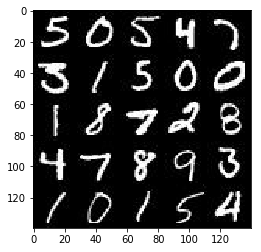

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

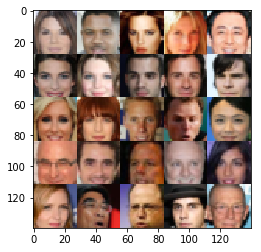

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='inputs_z')
    learning_rate = tf.placeholder(tf.float32, None, name='learning_rate')
    
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def leakyReLU(x, alpha=0.2):
    return tf.maximum(alpha * x, x)


def discriminator(images, reuse=False, alpha=0.2, keep_prob=0.8):
    """
    Create the discriminator network
    :param images: Tensor of input image(s) //dataset will be in the range of -0.5 to 0.5 of 28x28
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # Improvements: use odd-sized filters. Kernel size of 5 is a better choice nstead of 4.
    
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        c1 = tf.layers.conv2d(images, filters=128, kernel_size=(5,5), strides=(2,2), padding='same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        relu1 = leakyReLU(c1, alpha)
        d1 = tf.nn.dropout(relu1, keep_prob=keep_prob)
    
        #print(relu1.shape)
        # now 14x14x128
        
        c2 = tf.layers.conv2d(d1, filters=256, kernel_size=(5,5), strides=(2,2), padding='same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        bn2 = tf.layers.batch_normalization(c2, training=True)
        relu2 = leakyReLU(bn2, alpha)
        d2 = tf.nn.dropout(relu2, keep_prob=keep_prob)
        
        #print(relu2.shape)
        # now 7x7x256
        
        c3 = tf.layers.conv2d(d2, filters=512, kernel_size=(5,5), strides=(2,2), padding='same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        bn3 = tf.layers.batch_normalization(c3, training=True)
        relu3 = leakyReLU(bn3, alpha)
        d3 = tf.nn.dropout(relu3, keep_prob=keep_prob)
        
        #print(relu3.shape)
        # now 4x4x512


        # Flatten it
        flat = tf.reshape(d3, (-1, 4*4*512))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function

    # Model tipss:
    # - use 5 layers, 3 layers are not enough
    # - generators which are sufficiently larger than the discriminator tend to produce better samples.
    
    with tf.variable_scope('generator', reuse=not is_train):
        # project input vector with fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        bn1 = tf.layers.batch_normalization(x1, training=is_train)
        relu1 = leakyReLU(bn1)
        
        #print(relu1.shape)
        # 7x7x512 now
        
        ct2 = tf.layers.conv2d_transpose(relu1, 256, kernel_size=(5,5), strides=(2,2), padding='same',
                                        kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        bn2 = tf.layers.batch_normalization(ct2, training=is_train)
        relu2 = leakyReLU(bn2)
        
        #print(relu2.shape)
        # 14x14x256 now
        
        ct3 = tf.layers.conv2d_transpose(relu2, 128, kernel_size=(5,5), strides=(2,2), padding='same',
                                        kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        bn3 = tf.layers.batch_normalization(ct3, training=is_train)
        relu3 = leakyReLU(bn3)
        
        #print(relu3.shape)
        # 28x28x128 now
        
        ct4 = tf.layers.conv2d_transpose(relu3, 64, kernel_size=(5,5), strides=(1,1), padding='same',
                                        kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        bn4 = tf.layers.batch_normalization(ct4, training=is_train)
        relu4 = leakyReLU(bn4)
        
        #print(relu4.shape)
        # 28x28x64 now

        # Output layer
        # strides 1 to avoid checkerboard-like artifacts in the generated images. See: https://distill.pub/2016/deconv-checkerboard/
        logits = tf.layers.conv2d_transpose(relu4, out_channel_dim, kernel_size=(5,5), strides=(1,1), padding='same',
                                           kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        
        print(logits.shape)
        # 28x28xoutput_dim now
         
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

(?, 28, 28, 5)
(?, 28, 28, 5)
Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, smooth = 0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    d_out_real, d_logits_real = discriminator(input_real, reuse=False)
    g_out_fake = generator(input_z, out_channel_dim, is_train=True)
    d_out_fake, d_logits_fake = discriminator(g_out_fake, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                labels=tf.ones_like(d_out_real) * (1 - smooth)))
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                labels=tf.zeros_like(d_out_fake)))
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                labels=tf.ones_like(d_out_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

(?, 28, 28, 4)
Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function

    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

    return None, None


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
   
    
    #? tf.reset_default_graph()
    print(data_shape)
    _, image_width, image_height, image_channels = data_shape
    
    # get placeholders
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    
    # get losses
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    
    # get optimizers    
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    # Train Model
    print_every = 25
    show_every = 200
    saver = tf.train.Saver()
    
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                # Scale images: 
                #   The output from the generator is bound between -1 and 1 as tanh activation function is used in the output layer. 
                #   The input batch images are in the range -0.5 to 0.5. They must be scaled to match the values as in generated image. 
                batch_images = batch_images * 2
                
                # TODO: Train Model
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, 
                                               input_z: batch_z, 
                                               lr:learning_rate})
                
                _ = sess.run(g_opt, feed_dict={input_real: batch_images,
                                               input_z: batch_z, 
                                               lr:learning_rate})
                # Execute the optimization for generator twice. 
                # This ensures that the discriminator loss does not go to 0 and impede learning.
                _ = sess.run(g_opt, feed_dict={input_real: batch_images,
                                               input_z: batch_z, 
                                               lr:learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_real: batch_images,
                                                input_z: batch_z, 
                                                lr:learning_rate})
                    
                    train_loss_g = g_loss.eval({input_real: batch_images,
                                                input_z: batch_z, 
                                                lr:learning_rate})

                    print("Epoch: {}/{};".format(epoch_i+1, epochs),
                          "Batch: {:5d};".format(steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)

                    
        saver.save(sess, './generator.ckpt')


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

(60000, 28, 28, 1)
(?, 28, 28, 1)
Epoch: 1/2; Batch:    25; Discriminator Loss: 3.8439... Generator Loss: 0.1239
Epoch: 1/2; Batch:    50; Discriminator Loss: 2.6487... Generator Loss: 1.8187
Epoch: 1/2; Batch:    75; Discriminator Loss: 2.0311... Generator Loss: 0.3320
Epoch: 1/2; Batch:   100; Discriminator Loss: 1.8984... Generator Loss: 0.9474
Epoch: 1/2; Batch:   125; Discriminator Loss: 1.6306... Generator Loss: 0.4834
Epoch: 1/2; Batch:   150; Discriminator Loss: 1.6856... Generator Loss: 0.6062
Epoch: 1/2; Batch:   175; Discriminator Loss: 2.0238... Generator Loss: 0.2354
Epoch: 1/2; Batch:   200; Discriminator Loss: 1.6738... Generator Loss: 0.8192
(?, 28, 28, 1)


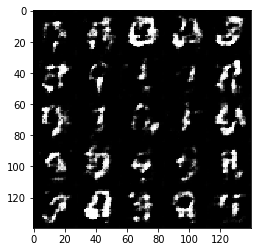

Epoch: 1/2; Batch:   225; Discriminator Loss: 1.6364... Generator Loss: 1.0388
Epoch: 1/2; Batch:   250; Discriminator Loss: 1.7834... Generator Loss: 0.7016
Epoch: 1/2; Batch:   275; Discriminator Loss: 1.6437... Generator Loss: 0.6833
Epoch: 1/2; Batch:   300; Discriminator Loss: 1.5640... Generator Loss: 0.9694
Epoch: 1/2; Batch:   325; Discriminator Loss: 1.5203... Generator Loss: 0.5091
Epoch: 1/2; Batch:   350; Discriminator Loss: 1.4737... Generator Loss: 0.5757
Epoch: 1/2; Batch:   375; Discriminator Loss: 1.6898... Generator Loss: 1.1734
Epoch: 1/2; Batch:   400; Discriminator Loss: 1.6088... Generator Loss: 0.8531
(?, 28, 28, 1)


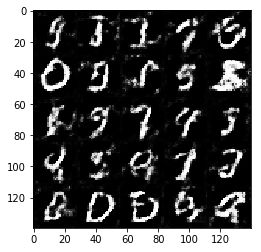

Epoch: 1/2; Batch:   425; Discriminator Loss: 1.6449... Generator Loss: 0.4100
Epoch: 1/2; Batch:   450; Discriminator Loss: 1.6036... Generator Loss: 0.5526
Epoch: 1/2; Batch:   475; Discriminator Loss: 1.5613... Generator Loss: 0.7465
Epoch: 1/2; Batch:   500; Discriminator Loss: 1.5889... Generator Loss: 0.6883
Epoch: 1/2; Batch:   525; Discriminator Loss: 1.6606... Generator Loss: 1.0614
Epoch: 1/2; Batch:   550; Discriminator Loss: 1.7750... Generator Loss: 0.3807
Epoch: 1/2; Batch:   575; Discriminator Loss: 1.8404... Generator Loss: 0.3717
Epoch: 1/2; Batch:   600; Discriminator Loss: 1.5004... Generator Loss: 0.6150
(?, 28, 28, 1)


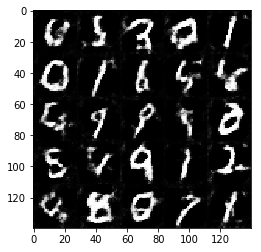

Epoch: 1/2; Batch:   625; Discriminator Loss: 1.6347... Generator Loss: 0.4836
Epoch: 1/2; Batch:   650; Discriminator Loss: 1.6124... Generator Loss: 0.4661
Epoch: 1/2; Batch:   675; Discriminator Loss: 1.5869... Generator Loss: 0.7403
Epoch: 1/2; Batch:   700; Discriminator Loss: 1.6321... Generator Loss: 0.3926
Epoch: 1/2; Batch:   725; Discriminator Loss: 1.4501... Generator Loss: 0.8399
Epoch: 1/2; Batch:   750; Discriminator Loss: 1.6926... Generator Loss: 0.4171
Epoch: 1/2; Batch:   775; Discriminator Loss: 1.7685... Generator Loss: 0.3539
Epoch: 1/2; Batch:   800; Discriminator Loss: 1.5238... Generator Loss: 1.0365
(?, 28, 28, 1)


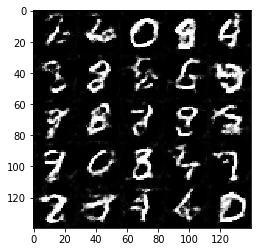

Epoch: 1/2; Batch:   825; Discriminator Loss: 1.3651... Generator Loss: 1.1666
Epoch: 1/2; Batch:   850; Discriminator Loss: 1.7388... Generator Loss: 0.5073
Epoch: 1/2; Batch:   875; Discriminator Loss: 1.5093... Generator Loss: 0.5955
Epoch: 1/2; Batch:   900; Discriminator Loss: 1.4833... Generator Loss: 0.6413
Epoch: 1/2; Batch:   925; Discriminator Loss: 1.5037... Generator Loss: 0.5031
Epoch: 1/2; Batch:   950; Discriminator Loss: 1.5166... Generator Loss: 1.1168
Epoch: 1/2; Batch:   975; Discriminator Loss: 1.6452... Generator Loss: 0.3720
Epoch: 1/2; Batch:  1000; Discriminator Loss: 1.5531... Generator Loss: 0.4767
(?, 28, 28, 1)


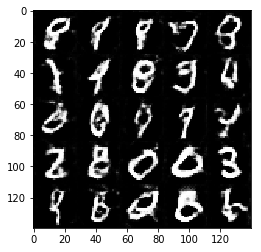

Epoch: 1/2; Batch:  1025; Discriminator Loss: 1.5266... Generator Loss: 0.7006
Epoch: 1/2; Batch:  1050; Discriminator Loss: 1.8218... Generator Loss: 0.3679
Epoch: 1/2; Batch:  1075; Discriminator Loss: 1.4832... Generator Loss: 0.5984
Epoch: 1/2; Batch:  1100; Discriminator Loss: 1.5670... Generator Loss: 0.9249
Epoch: 1/2; Batch:  1125; Discriminator Loss: 1.7844... Generator Loss: 0.3478
Epoch: 1/2; Batch:  1150; Discriminator Loss: 1.4897... Generator Loss: 0.7334
Epoch: 1/2; Batch:  1175; Discriminator Loss: 1.6226... Generator Loss: 0.5811
Epoch: 1/2; Batch:  1200; Discriminator Loss: 1.6580... Generator Loss: 1.0483
(?, 28, 28, 1)


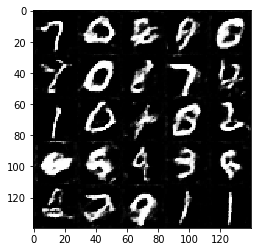

Epoch: 1/2; Batch:  1225; Discriminator Loss: 1.3919... Generator Loss: 0.6807
Epoch: 1/2; Batch:  1250; Discriminator Loss: 1.6068... Generator Loss: 0.4444
Epoch: 1/2; Batch:  1275; Discriminator Loss: 1.4928... Generator Loss: 0.6795
Epoch: 1/2; Batch:  1300; Discriminator Loss: 1.5107... Generator Loss: 0.5008
Epoch: 1/2; Batch:  1325; Discriminator Loss: 1.6709... Generator Loss: 0.4159
Epoch: 1/2; Batch:  1350; Discriminator Loss: 1.5321... Generator Loss: 0.5282
Epoch: 1/2; Batch:  1375; Discriminator Loss: 1.4686... Generator Loss: 0.8267
Epoch: 1/2; Batch:  1400; Discriminator Loss: 1.5639... Generator Loss: 1.3273
(?, 28, 28, 1)


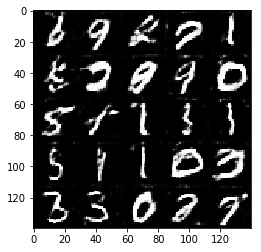

Epoch: 1/2; Batch:  1425; Discriminator Loss: 1.5870... Generator Loss: 0.7944
Epoch: 1/2; Batch:  1450; Discriminator Loss: 1.5637... Generator Loss: 0.5936
Epoch: 1/2; Batch:  1475; Discriminator Loss: 1.4137... Generator Loss: 0.8779
Epoch: 1/2; Batch:  1500; Discriminator Loss: 1.5881... Generator Loss: 1.0355
Epoch: 1/2; Batch:  1525; Discriminator Loss: 1.4031... Generator Loss: 0.8366
Epoch: 1/2; Batch:  1550; Discriminator Loss: 1.4544... Generator Loss: 0.6317
Epoch: 1/2; Batch:  1575; Discriminator Loss: 1.3663... Generator Loss: 0.6803
Epoch: 1/2; Batch:  1600; Discriminator Loss: 1.4548... Generator Loss: 1.0009
(?, 28, 28, 1)


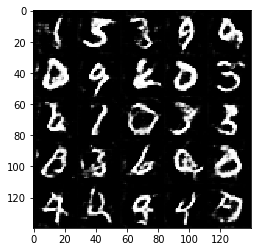

Epoch: 1/2; Batch:  1625; Discriminator Loss: 1.5146... Generator Loss: 1.0479
Epoch: 1/2; Batch:  1650; Discriminator Loss: 1.6947... Generator Loss: 0.3741
Epoch: 1/2; Batch:  1675; Discriminator Loss: 1.5317... Generator Loss: 0.4118
Epoch: 1/2; Batch:  1700; Discriminator Loss: 1.3988... Generator Loss: 0.8041
Epoch: 1/2; Batch:  1725; Discriminator Loss: 1.3713... Generator Loss: 0.7835
Epoch: 1/2; Batch:  1750; Discriminator Loss: 1.4101... Generator Loss: 0.6919
Epoch: 1/2; Batch:  1775; Discriminator Loss: 1.5235... Generator Loss: 0.6475
Epoch: 1/2; Batch:  1800; Discriminator Loss: 1.5847... Generator Loss: 0.4467
(?, 28, 28, 1)


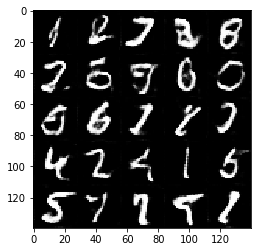

Epoch: 1/2; Batch:  1825; Discriminator Loss: 1.5362... Generator Loss: 0.5417
Epoch: 1/2; Batch:  1850; Discriminator Loss: 1.5433... Generator Loss: 0.6979
Epoch: 1/2; Batch:  1875; Discriminator Loss: 1.3765... Generator Loss: 1.0496
Epoch: 2/2; Batch:  1900; Discriminator Loss: 1.4516... Generator Loss: 0.7920
Epoch: 2/2; Batch:  1925; Discriminator Loss: 1.5989... Generator Loss: 0.4417
Epoch: 2/2; Batch:  1950; Discriminator Loss: 1.4188... Generator Loss: 0.9482
Epoch: 2/2; Batch:  1975; Discriminator Loss: 1.5244... Generator Loss: 0.5448
Epoch: 2/2; Batch:  2000; Discriminator Loss: 1.4117... Generator Loss: 0.7936
(?, 28, 28, 1)


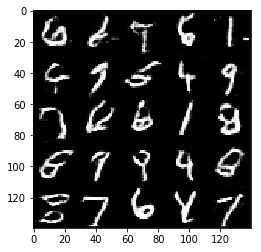

Epoch: 2/2; Batch:  2025; Discriminator Loss: 1.6573... Generator Loss: 0.3610
Epoch: 2/2; Batch:  2050; Discriminator Loss: 1.4206... Generator Loss: 0.5291
Epoch: 2/2; Batch:  2075; Discriminator Loss: 1.6147... Generator Loss: 0.9938
Epoch: 2/2; Batch:  2100; Discriminator Loss: 1.4680... Generator Loss: 0.6120
Epoch: 2/2; Batch:  2125; Discriminator Loss: 1.3614... Generator Loss: 0.7658
Epoch: 2/2; Batch:  2150; Discriminator Loss: 1.5715... Generator Loss: 0.3962
Epoch: 2/2; Batch:  2175; Discriminator Loss: 1.3137... Generator Loss: 0.9601
Epoch: 2/2; Batch:  2200; Discriminator Loss: 1.4699... Generator Loss: 0.7698
(?, 28, 28, 1)


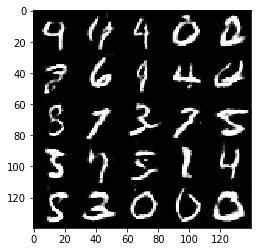

Epoch: 2/2; Batch:  2225; Discriminator Loss: 1.5127... Generator Loss: 0.4952
Epoch: 2/2; Batch:  2250; Discriminator Loss: 1.3557... Generator Loss: 0.6763
Epoch: 2/2; Batch:  2275; Discriminator Loss: 1.3269... Generator Loss: 0.7212
Epoch: 2/2; Batch:  2300; Discriminator Loss: 1.4098... Generator Loss: 0.6287
Epoch: 2/2; Batch:  2325; Discriminator Loss: 1.4891... Generator Loss: 0.5817
Epoch: 2/2; Batch:  2350; Discriminator Loss: 1.4358... Generator Loss: 0.5505
Epoch: 2/2; Batch:  2375; Discriminator Loss: 1.4442... Generator Loss: 0.6228
Epoch: 2/2; Batch:  2400; Discriminator Loss: 1.5151... Generator Loss: 0.9396
(?, 28, 28, 1)


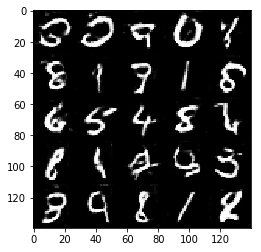

Epoch: 2/2; Batch:  2425; Discriminator Loss: 1.4629... Generator Loss: 0.5638
Epoch: 2/2; Batch:  2450; Discriminator Loss: 1.5021... Generator Loss: 0.8677
Epoch: 2/2; Batch:  2475; Discriminator Loss: 1.4342... Generator Loss: 0.5521
Epoch: 2/2; Batch:  2500; Discriminator Loss: 1.5377... Generator Loss: 0.8413
Epoch: 2/2; Batch:  2525; Discriminator Loss: 1.6171... Generator Loss: 0.4280
Epoch: 2/2; Batch:  2550; Discriminator Loss: 1.3119... Generator Loss: 0.9376
Epoch: 2/2; Batch:  2575; Discriminator Loss: 1.4012... Generator Loss: 0.7467
Epoch: 2/2; Batch:  2600; Discriminator Loss: 1.5377... Generator Loss: 0.8512
(?, 28, 28, 1)


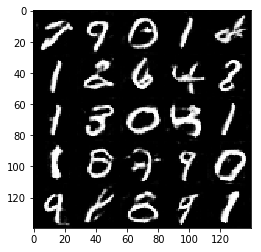

Epoch: 2/2; Batch:  2625; Discriminator Loss: 1.5489... Generator Loss: 0.3911
Epoch: 2/2; Batch:  2650; Discriminator Loss: 1.4393... Generator Loss: 0.6332
Epoch: 2/2; Batch:  2675; Discriminator Loss: 1.3292... Generator Loss: 0.8029
Epoch: 2/2; Batch:  2700; Discriminator Loss: 1.4766... Generator Loss: 0.5423
Epoch: 2/2; Batch:  2725; Discriminator Loss: 1.4913... Generator Loss: 0.5604
Epoch: 2/2; Batch:  2750; Discriminator Loss: 1.4511... Generator Loss: 0.6499
Epoch: 2/2; Batch:  2775; Discriminator Loss: 1.5181... Generator Loss: 1.0398
Epoch: 2/2; Batch:  2800; Discriminator Loss: 1.3274... Generator Loss: 1.0201
(?, 28, 28, 1)


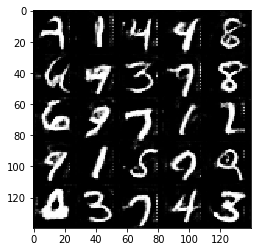

Epoch: 2/2; Batch:  2825; Discriminator Loss: 1.3534... Generator Loss: 0.9182
Epoch: 2/2; Batch:  2850; Discriminator Loss: 1.4352... Generator Loss: 0.6530
Epoch: 2/2; Batch:  2875; Discriminator Loss: 1.6135... Generator Loss: 1.5177
Epoch: 2/2; Batch:  2900; Discriminator Loss: 1.4478... Generator Loss: 1.3012
Epoch: 2/2; Batch:  2925; Discriminator Loss: 1.4907... Generator Loss: 0.6106
Epoch: 2/2; Batch:  2950; Discriminator Loss: 1.4799... Generator Loss: 0.7775
Epoch: 2/2; Batch:  2975; Discriminator Loss: 1.4183... Generator Loss: 0.7231
Epoch: 2/2; Batch:  3000; Discriminator Loss: 1.5300... Generator Loss: 0.5400
(?, 28, 28, 1)


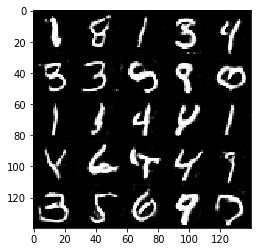

Epoch: 2/2; Batch:  3025; Discriminator Loss: 1.4218... Generator Loss: 0.5530
Epoch: 2/2; Batch:  3050; Discriminator Loss: 1.4520... Generator Loss: 0.5994
Epoch: 2/2; Batch:  3075; Discriminator Loss: 1.6311... Generator Loss: 1.0525
Epoch: 2/2; Batch:  3100; Discriminator Loss: 1.5162... Generator Loss: 0.5413
Epoch: 2/2; Batch:  3125; Discriminator Loss: 1.6065... Generator Loss: 0.4385
Epoch: 2/2; Batch:  3150; Discriminator Loss: 1.3510... Generator Loss: 0.6905
Epoch: 2/2; Batch:  3175; Discriminator Loss: 1.5486... Generator Loss: 1.1856
Epoch: 2/2; Batch:  3200; Discriminator Loss: 1.4065... Generator Loss: 0.5722
(?, 28, 28, 1)


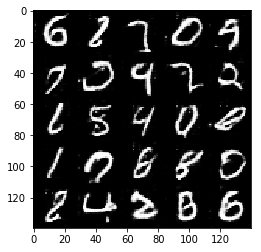

Epoch: 2/2; Batch:  3225; Discriminator Loss: 1.3765... Generator Loss: 1.0043
Epoch: 2/2; Batch:  3250; Discriminator Loss: 1.7071... Generator Loss: 0.6743
Epoch: 2/2; Batch:  3275; Discriminator Loss: 1.5089... Generator Loss: 0.9615
Epoch: 2/2; Batch:  3300; Discriminator Loss: 1.4106... Generator Loss: 0.8091
Epoch: 2/2; Batch:  3325; Discriminator Loss: 1.5996... Generator Loss: 0.4233
Epoch: 2/2; Batch:  3350; Discriminator Loss: 1.3899... Generator Loss: 0.7152
Epoch: 2/2; Batch:  3375; Discriminator Loss: 1.4263... Generator Loss: 1.1088
Epoch: 2/2; Batch:  3400; Discriminator Loss: 1.2895... Generator Loss: 0.5928
(?, 28, 28, 1)


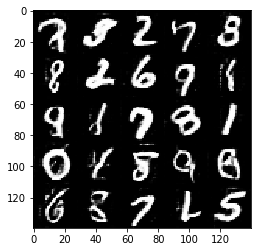

Epoch: 2/2; Batch:  3425; Discriminator Loss: 1.3305... Generator Loss: 1.1971
Epoch: 2/2; Batch:  3450; Discriminator Loss: 1.4339... Generator Loss: 1.1236
Epoch: 2/2; Batch:  3475; Discriminator Loss: 1.4066... Generator Loss: 0.6803
Epoch: 2/2; Batch:  3500; Discriminator Loss: 1.3579... Generator Loss: 0.8203
Epoch: 2/2; Batch:  3525; Discriminator Loss: 1.4253... Generator Loss: 0.9780
Epoch: 2/2; Batch:  3550; Discriminator Loss: 1.3622... Generator Loss: 0.9328
Epoch: 2/2; Batch:  3575; Discriminator Loss: 1.3474... Generator Loss: 0.7038
Epoch: 2/2; Batch:  3600; Discriminator Loss: 1.3285... Generator Loss: 1.1554
(?, 28, 28, 1)


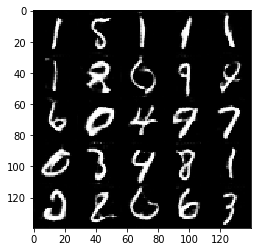

Epoch: 2/2; Batch:  3625; Discriminator Loss: 1.5477... Generator Loss: 1.1006
Epoch: 2/2; Batch:  3650; Discriminator Loss: 1.3281... Generator Loss: 0.9186
Epoch: 2/2; Batch:  3675; Discriminator Loss: 1.4914... Generator Loss: 0.4776
Epoch: 2/2; Batch:  3700; Discriminator Loss: 1.4274... Generator Loss: 0.4579
Epoch: 2/2; Batch:  3725; Discriminator Loss: 1.3992... Generator Loss: 1.0006
Epoch: 2/2; Batch:  3750; Discriminator Loss: 1.4493... Generator Loss: 1.2563


In [ ]:
batch_size = 32
z_dim = 200
learning_rate = 0.001
beta1 = 0.2
# ==> Generator Loss gets bigger over, imgages gets bader

batch_size = 32
z_dim = 200
learning_rate = 0.0001
beta1 = 0.2

batch_size = 64
z_dim = 100
learning_rate = 0.0004
beta1 = 0.3

batch_size = 32
z_dim = 128
learning_rate = 0.0005
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

(202599, 28, 28, 3)
(?, 28, 28, 3)
Epoch: 1/1; Batch:    25; Discriminator Loss: 3.7825... Generator Loss: 0.0703
Epoch: 1/1; Batch:    50; Discriminator Loss: 1.9068... Generator Loss: 0.5315
Epoch: 1/1; Batch:    75; Discriminator Loss: 1.7285... Generator Loss: 1.1433
Epoch: 1/1; Batch:   100; Discriminator Loss: 1.6675... Generator Loss: 0.5098
Epoch: 1/1; Batch:   125; Discriminator Loss: 1.7168... Generator Loss: 0.4698
Epoch: 1/1; Batch:   150; Discriminator Loss: 2.0271... Generator Loss: 0.3292
Epoch: 1/1; Batch:   175; Discriminator Loss: 1.5574... Generator Loss: 0.7807
Epoch: 1/1; Batch:   200; Discriminator Loss: 1.5638... Generator Loss: 0.8267
(?, 28, 28, 3)


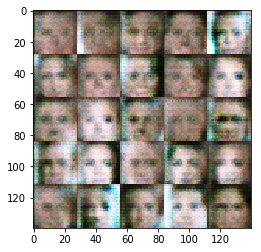

Epoch: 1/1; Batch:   225; Discriminator Loss: 1.5796... Generator Loss: 0.8904
Epoch: 1/1; Batch:   250; Discriminator Loss: 1.7225... Generator Loss: 0.6988
Epoch: 1/1; Batch:   275; Discriminator Loss: 1.6993... Generator Loss: 0.5176
Epoch: 1/1; Batch:   300; Discriminator Loss: 1.5003... Generator Loss: 0.5759
Epoch: 1/1; Batch:   325; Discriminator Loss: 1.5842... Generator Loss: 0.7555
Epoch: 1/1; Batch:   350; Discriminator Loss: 1.5645... Generator Loss: 0.5474
Epoch: 1/1; Batch:   375; Discriminator Loss: 1.5396... Generator Loss: 0.7635
Epoch: 1/1; Batch:   400; Discriminator Loss: 1.6175... Generator Loss: 0.5888
(?, 28, 28, 3)


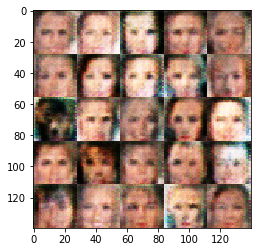

Epoch: 1/1; Batch:   425; Discriminator Loss: 1.4467... Generator Loss: 0.6204
Epoch: 1/1; Batch:   450; Discriminator Loss: 1.5156... Generator Loss: 0.6869
Epoch: 1/1; Batch:   475; Discriminator Loss: 1.4396... Generator Loss: 0.6197
Epoch: 1/1; Batch:   500; Discriminator Loss: 1.5928... Generator Loss: 0.6123
Epoch: 1/1; Batch:   525; Discriminator Loss: 1.4274... Generator Loss: 0.6600
Epoch: 1/1; Batch:   550; Discriminator Loss: 1.4191... Generator Loss: 0.8901
Epoch: 1/1; Batch:   575; Discriminator Loss: 1.4992... Generator Loss: 0.8702
Epoch: 1/1; Batch:   600; Discriminator Loss: 1.6103... Generator Loss: 0.5348
(?, 28, 28, 3)


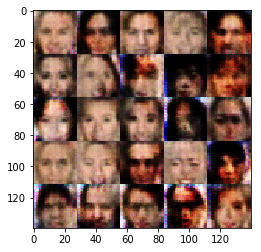

Epoch: 1/1; Batch:   625; Discriminator Loss: 1.5661... Generator Loss: 0.8386
Epoch: 1/1; Batch:   650; Discriminator Loss: 1.5201... Generator Loss: 0.5721
Epoch: 1/1; Batch:   675; Discriminator Loss: 1.4979... Generator Loss: 0.8112
Epoch: 1/1; Batch:   700; Discriminator Loss: 1.5306... Generator Loss: 0.8832
Epoch: 1/1; Batch:   725; Discriminator Loss: 1.4436... Generator Loss: 0.6751
Epoch: 1/1; Batch:   750; Discriminator Loss: 1.5800... Generator Loss: 0.8910
Epoch: 1/1; Batch:   775; Discriminator Loss: 1.4793... Generator Loss: 0.7956
Epoch: 1/1; Batch:   800; Discriminator Loss: 1.7282... Generator Loss: 0.6077
(?, 28, 28, 3)


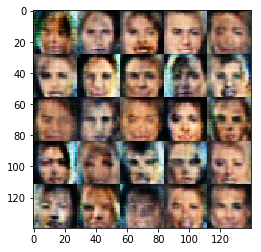

Epoch: 1/1; Batch:   825; Discriminator Loss: 1.5445... Generator Loss: 0.6755
Epoch: 1/1; Batch:   850; Discriminator Loss: 1.4809... Generator Loss: 0.7320
Epoch: 1/1; Batch:   875; Discriminator Loss: 1.4155... Generator Loss: 0.9854
Epoch: 1/1; Batch:   900; Discriminator Loss: 1.6451... Generator Loss: 0.5716
Epoch: 1/1; Batch:   925; Discriminator Loss: 1.6854... Generator Loss: 0.5999
Epoch: 1/1; Batch:   950; Discriminator Loss: 1.4441... Generator Loss: 0.6552
Epoch: 1/1; Batch:   975; Discriminator Loss: 1.4595... Generator Loss: 0.9087
Epoch: 1/1; Batch:  1000; Discriminator Loss: 1.6048... Generator Loss: 0.5627
(?, 28, 28, 3)


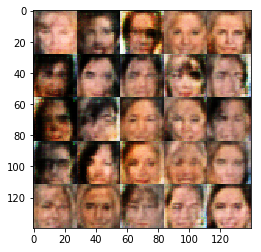

Epoch: 1/1; Batch:  1025; Discriminator Loss: 1.6462... Generator Loss: 0.6935
Epoch: 1/1; Batch:  1050; Discriminator Loss: 1.4712... Generator Loss: 0.8321
Epoch: 1/1; Batch:  1075; Discriminator Loss: 1.5365... Generator Loss: 0.6535
Epoch: 1/1; Batch:  1100; Discriminator Loss: 1.4470... Generator Loss: 0.7621
Epoch: 1/1; Batch:  1125; Discriminator Loss: 1.4805... Generator Loss: 0.7166
Epoch: 1/1; Batch:  1150; Discriminator Loss: 1.4943... Generator Loss: 0.8491
Epoch: 1/1; Batch:  1175; Discriminator Loss: 1.4935... Generator Loss: 0.8355
Epoch: 1/1; Batch:  1200; Discriminator Loss: 1.5210... Generator Loss: 0.7692
(?, 28, 28, 3)


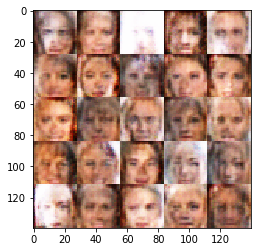

Epoch: 1/1; Batch:  1225; Discriminator Loss: 1.5483... Generator Loss: 0.7023
Epoch: 1/1; Batch:  1250; Discriminator Loss: 1.5977... Generator Loss: 0.6595
Epoch: 1/1; Batch:  1275; Discriminator Loss: 1.4137... Generator Loss: 0.5561
Epoch: 1/1; Batch:  1300; Discriminator Loss: 1.5280... Generator Loss: 0.6013
Epoch: 1/1; Batch:  1325; Discriminator Loss: 1.4273... Generator Loss: 0.6184
Epoch: 1/1; Batch:  1350; Discriminator Loss: 1.5362... Generator Loss: 0.8159
Epoch: 1/1; Batch:  1375; Discriminator Loss: 1.6079... Generator Loss: 0.7364
Epoch: 1/1; Batch:  1400; Discriminator Loss: 1.5943... Generator Loss: 0.6639
(?, 28, 28, 3)


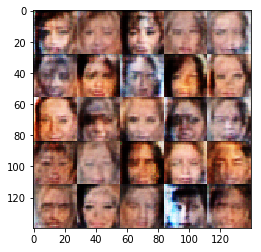

Epoch: 1/1; Batch:  1425; Discriminator Loss: 1.4841... Generator Loss: 0.6884
Epoch: 1/1; Batch:  1450; Discriminator Loss: 1.4437... Generator Loss: 0.8144
Epoch: 1/1; Batch:  1475; Discriminator Loss: 1.4689... Generator Loss: 0.9040
Epoch: 1/1; Batch:  1500; Discriminator Loss: 1.4775... Generator Loss: 0.7945
Epoch: 1/1; Batch:  1525; Discriminator Loss: 1.4693... Generator Loss: 0.8138
Epoch: 1/1; Batch:  1550; Discriminator Loss: 1.5200... Generator Loss: 0.9447
Epoch: 1/1; Batch:  1575; Discriminator Loss: 1.4611... Generator Loss: 0.7948
Epoch: 1/1; Batch:  1600; Discriminator Loss: 1.5395... Generator Loss: 0.7588
(?, 28, 28, 3)


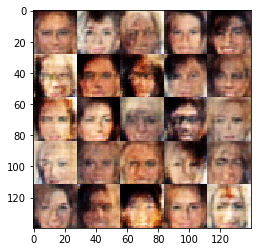

Epoch: 1/1; Batch:  1625; Discriminator Loss: 1.4357... Generator Loss: 0.6816
Epoch: 1/1; Batch:  1650; Discriminator Loss: 1.4792... Generator Loss: 0.7710
Epoch: 1/1; Batch:  1675; Discriminator Loss: 1.5993... Generator Loss: 0.6625
Epoch: 1/1; Batch:  1700; Discriminator Loss: 1.4445... Generator Loss: 0.7247
Epoch: 1/1; Batch:  1725; Discriminator Loss: 1.5164... Generator Loss: 0.6984
Epoch: 1/1; Batch:  1750; Discriminator Loss: 1.6341... Generator Loss: 0.6220
Epoch: 1/1; Batch:  1775; Discriminator Loss: 1.4193... Generator Loss: 0.9354
Epoch: 1/1; Batch:  1800; Discriminator Loss: 1.5611... Generator Loss: 0.7815
(?, 28, 28, 3)


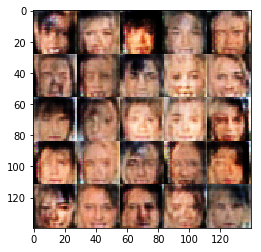

Epoch: 1/1; Batch:  1825; Discriminator Loss: 1.4398... Generator Loss: 0.7877
Epoch: 1/1; Batch:  1850; Discriminator Loss: 1.4880... Generator Loss: 0.6701
Epoch: 1/1; Batch:  1875; Discriminator Loss: 1.5691... Generator Loss: 0.6997
Epoch: 1/1; Batch:  1900; Discriminator Loss: 1.4319... Generator Loss: 0.8307
Epoch: 1/1; Batch:  1925; Discriminator Loss: 1.4511... Generator Loss: 0.9088
Epoch: 1/1; Batch:  1950; Discriminator Loss: 1.4305... Generator Loss: 0.7624
Epoch: 1/1; Batch:  1975; Discriminator Loss: 1.4408... Generator Loss: 0.9044
Epoch: 1/1; Batch:  2000; Discriminator Loss: 1.3726... Generator Loss: 0.8504
(?, 28, 28, 3)


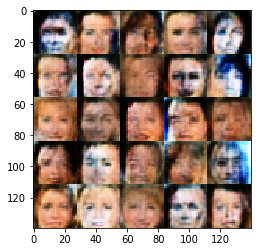

Epoch: 1/1; Batch:  2025; Discriminator Loss: 1.4958... Generator Loss: 0.6838
Epoch: 1/1; Batch:  2050; Discriminator Loss: 1.4950... Generator Loss: 0.6871
Epoch: 1/1; Batch:  2075; Discriminator Loss: 1.4058... Generator Loss: 0.7518
Epoch: 1/1; Batch:  2100; Discriminator Loss: 1.5277... Generator Loss: 0.8310
Epoch: 1/1; Batch:  2125; Discriminator Loss: 1.4166... Generator Loss: 0.7150
Epoch: 1/1; Batch:  2150; Discriminator Loss: 1.5337... Generator Loss: 0.8799
Epoch: 1/1; Batch:  2175; Discriminator Loss: 1.4520... Generator Loss: 0.6552
Epoch: 1/1; Batch:  2200; Discriminator Loss: 1.5221... Generator Loss: 0.6814
(?, 28, 28, 3)


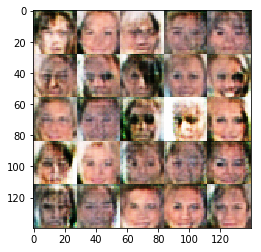

Epoch: 1/1; Batch:  2225; Discriminator Loss: 1.4741... Generator Loss: 0.7721
Epoch: 1/1; Batch:  2250; Discriminator Loss: 1.4750... Generator Loss: 0.7342
Epoch: 1/1; Batch:  2275; Discriminator Loss: 1.5577... Generator Loss: 0.7625
Epoch: 1/1; Batch:  2300; Discriminator Loss: 1.4913... Generator Loss: 0.7976
Epoch: 1/1; Batch:  2325; Discriminator Loss: 1.4119... Generator Loss: 0.7957
Epoch: 1/1; Batch:  2350; Discriminator Loss: 1.4700... Generator Loss: 0.7060
Epoch: 1/1; Batch:  2375; Discriminator Loss: 1.4328... Generator Loss: 0.9314
Epoch: 1/1; Batch:  2400; Discriminator Loss: 1.4910... Generator Loss: 0.7108
(?, 28, 28, 3)


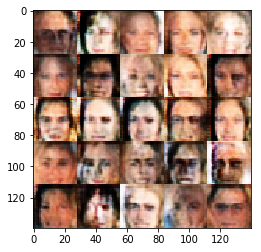

Epoch: 1/1; Batch:  4950; Discriminator Loss: 1.4781... Generator Loss: 0.7093
Epoch: 1/1; Batch:  4975; Discriminator Loss: 1.3717... Generator Loss: 0.7541
Epoch: 1/1; Batch:  5000; Discriminator Loss: 1.3970... Generator Loss: 0.9040
(?, 28, 28, 3)


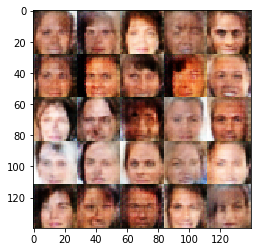

Epoch: 1/1; Batch:  5025; Discriminator Loss: 1.4346... Generator Loss: 0.6707
Epoch: 1/1; Batch:  5050; Discriminator Loss: 1.4037... Generator Loss: 0.6928
Epoch: 1/1; Batch:  5075; Discriminator Loss: 1.4061... Generator Loss: 0.7365
Epoch: 1/1; Batch:  5100; Discriminator Loss: 1.4910... Generator Loss: 0.7358
Epoch: 1/1; Batch:  5125; Discriminator Loss: 1.4372... Generator Loss: 0.7663
Epoch: 1/1; Batch:  5150; Discriminator Loss: 1.5505... Generator Loss: 0.6153
Epoch: 1/1; Batch:  5175; Discriminator Loss: 1.4528... Generator Loss: 0.7180
Epoch: 1/1; Batch:  5200; Discriminator Loss: 1.3913... Generator Loss: 0.8711
(?, 28, 28, 3)


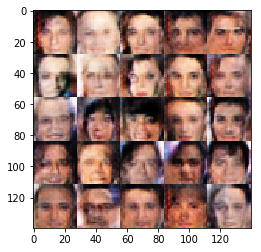

Epoch: 1/1; Batch:  5225; Discriminator Loss: 1.4001... Generator Loss: 0.8324
Epoch: 1/1; Batch:  5250; Discriminator Loss: 1.4741... Generator Loss: 0.6549
Epoch: 1/1; Batch:  5275; Discriminator Loss: 1.5438... Generator Loss: 0.6758
Epoch: 1/1; Batch:  5300; Discriminator Loss: 1.4685... Generator Loss: 0.7318
Epoch: 1/1; Batch:  5325; Discriminator Loss: 1.4907... Generator Loss: 0.7917
Epoch: 1/1; Batch:  5350; Discriminator Loss: 1.3943... Generator Loss: 0.7290
Epoch: 1/1; Batch:  5375; Discriminator Loss: 1.3617... Generator Loss: 0.7739
Epoch: 1/1; Batch:  5400; Discriminator Loss: 1.4831... Generator Loss: 0.6549
(?, 28, 28, 3)


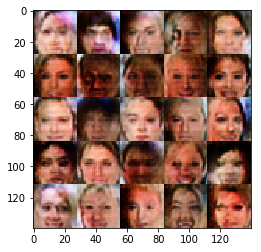

Epoch: 1/1; Batch:  5425; Discriminator Loss: 1.4077... Generator Loss: 0.6944
Epoch: 1/1; Batch:  5450; Discriminator Loss: 1.4448... Generator Loss: 0.7596
Epoch: 1/1; Batch:  5475; Discriminator Loss: 1.4080... Generator Loss: 0.7667
Epoch: 1/1; Batch:  5500; Discriminator Loss: 1.4303... Generator Loss: 0.7320
Epoch: 1/1; Batch:  5525; Discriminator Loss: 1.4454... Generator Loss: 0.7079
Epoch: 1/1; Batch:  5550; Discriminator Loss: 1.4118... Generator Loss: 0.8499
Epoch: 1/1; Batch:  5575; Discriminator Loss: 1.4495... Generator Loss: 0.7951
Epoch: 1/1; Batch:  5600; Discriminator Loss: 1.3999... Generator Loss: 0.8380
(?, 28, 28, 3)


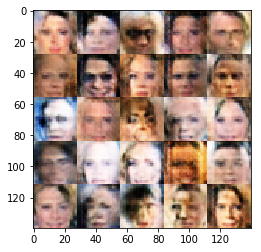

Epoch: 1/1; Batch:  5625; Discriminator Loss: 1.4300... Generator Loss: 0.7426
Epoch: 1/1; Batch:  5650; Discriminator Loss: 1.3526... Generator Loss: 0.8003
Epoch: 1/1; Batch:  5675; Discriminator Loss: 1.4420... Generator Loss: 0.6995
Epoch: 1/1; Batch:  5700; Discriminator Loss: 1.4566... Generator Loss: 0.6960
Epoch: 1/1; Batch:  5725; Discriminator Loss: 1.3544... Generator Loss: 0.8163
Epoch: 1/1; Batch:  5750; Discriminator Loss: 1.3980... Generator Loss: 0.9218
Epoch: 1/1; Batch:  5775; Discriminator Loss: 1.4033... Generator Loss: 0.7587
Epoch: 1/1; Batch:  5800; Discriminator Loss: 1.4138... Generator Loss: 0.7804
(?, 28, 28, 3)


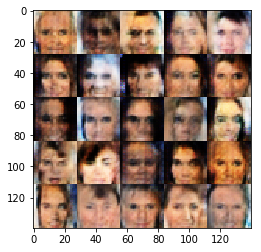

Epoch: 1/1; Batch:  5825; Discriminator Loss: 1.4647... Generator Loss: 0.7139
Epoch: 1/1; Batch:  5850; Discriminator Loss: 1.4165... Generator Loss: 0.6846
Epoch: 1/1; Batch:  5875; Discriminator Loss: 1.4492... Generator Loss: 0.7446
Epoch: 1/1; Batch:  5900; Discriminator Loss: 1.4217... Generator Loss: 0.8073
Epoch: 1/1; Batch:  5925; Discriminator Loss: 1.4519... Generator Loss: 0.7499
Epoch: 1/1; Batch:  5950; Discriminator Loss: 1.3984... Generator Loss: 0.7455
Epoch: 1/1; Batch:  5975; Discriminator Loss: 1.4034... Generator Loss: 0.7878
Epoch: 1/1; Batch:  6000; Discriminator Loss: 1.4187... Generator Loss: 0.7921
(?, 28, 28, 3)


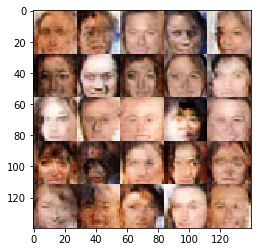

Epoch: 1/1; Batch:  6025; Discriminator Loss: 1.4507... Generator Loss: 0.7689
Epoch: 1/1; Batch:  6050; Discriminator Loss: 1.4019... Generator Loss: 0.8289
Epoch: 1/1; Batch:  6075; Discriminator Loss: 1.4228... Generator Loss: 0.7677
Epoch: 1/1; Batch:  6100; Discriminator Loss: 1.4271... Generator Loss: 0.6029
Epoch: 1/1; Batch:  6125; Discriminator Loss: 1.3563... Generator Loss: 0.7100
Epoch: 1/1; Batch:  6150; Discriminator Loss: 1.4205... Generator Loss: 0.7400
Epoch: 1/1; Batch:  6175; Discriminator Loss: 1.3680... Generator Loss: 0.7133
Epoch: 1/1; Batch:  6200; Discriminator Loss: 1.3577... Generator Loss: 0.8222
(?, 28, 28, 3)


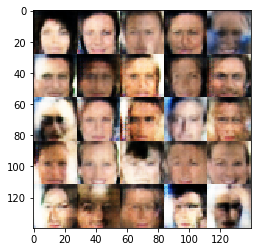

Epoch: 1/1; Batch:  6225; Discriminator Loss: 1.4038... Generator Loss: 0.7294
Epoch: 1/1; Batch:  6250; Discriminator Loss: 1.4194... Generator Loss: 0.7966
Epoch: 1/1; Batch:  6275; Discriminator Loss: 1.3725... Generator Loss: 0.6952
Epoch: 1/1; Batch:  6300; Discriminator Loss: 1.4308... Generator Loss: 0.7493
Epoch: 1/1; Batch:  6325; Discriminator Loss: 1.4322... Generator Loss: 0.7673


In [ ]:
batch_size = 32
z_dim = 128
learning_rate = 0.0005
beta1 = 0.3



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.

In [ ]:
print('the end')